特徴ベクトルをBOWで表現して記事分類
次元は大きいまま、重み付けもしない単純なBOW

In [19]:
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model,Sequential
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
import keras.backend as K
import random
import sys
import pickle
import glob
import copy
import os
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
from gensim import corpora,matutils
from sklearn.decomposition import PCA

In [20]:
categories=6

In [21]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [22]:
def train_test_divide(X,Y,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    return (X_train,Y_train),(X_test,Y_test)

In [23]:
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return words

In [24]:
def load_file(filename):
    words=[]
    cat=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            words.append(Wakati(title))
            cat.append(int(category))
    words,cat=shuffle(words,cat)
    return words,cat

In [25]:
words,cat=load_file("./data/yahoo_data.txt")
(train_words,train_cat),(test_words,test_cat)=train_test_divide(words,cat,0.1)
livedoor_words,livedoor_cat=load_file("./data/livedoor_data.txt")

(75600,)
(75600,)
(8399,)
(8399,)


In [41]:
#特徴語辞書作成
dictionary = corpora.Dictionary(train_words)
dictionary.filter_extremes(no_below=10, no_above=0.3)
dic_len=len(dictionary)
print(dic_len)
#print(dictionary.token2id)

6577


In [42]:
#辞書のセーブ
#dictionary.save_as_text('bowDictionary'+str(dic_len)+'.txt')

In [43]:
#辞書のロード
#dictionary = corpora.Dictionary.load_from_text('bowDictionary.txt')

In [44]:
def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

In [45]:
def create_data(words,cat):
    global dictionary
    X=[]
    Y=[]
    for i in range(len(words)):
        corpus = dictionary.doc2bow(words[i])
        bow_vec = list(matutils.corpus2dense([corpus], num_terms=len(dictionary)).T[0])
        y=onehot_vector(int(cat[i]))
        X.append(np.array(bow_vec))
        Y.append(np.array(y))
    X=np.array(X)
    Y=np.array(Y)
    return X,Y

In [46]:
def load_data(train_words,train_cat,test_words,test_cat):
    X_train,Y_train=create_data(train_words,train_cat)
    X_test,Y_test=create_data(test_words,test_cat)
    return (X_train,Y_train),(X_test,Y_test)

In [47]:
(X_train,Y_train),(X_test,Y_test)=load_data(train_words,train_cat,test_words,test_cat)
Livedoor_X,Livedoor_Y=create_data(livedoor_words,livedoor_cat)

In [48]:
#モデル作成
model = Sequential()
model.add(Dense(512, input_dim=dic_len,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(categories, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
#モデル学習
history =model.fit(X_train,Y_train,shuffle=True,batch_size=30,epochs=5,
                   validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               3367936   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 774       
Total params: 3,434,374
Trainable params: 3,434,374
Non-trainable params: 0
_________________________________________________________________
Train on 68040 samples, validate on 7560 samples
Epoch 1/5
68040/68040 [==============================] - 13s 193us/step - loss: 0.6222 - acc: 0.7854 - val_loss: 0.4988 - val_acc: 0.8308
Epoch 2/5
68040/68040 [==============================] - 13s 193us/step - loss: 0.3434 - acc: 0.8786 - val_loss: 0.5077 - val_acc: 0.8348
Epoch 3/5
68040/68040 [==============================] - 14s 202us/step

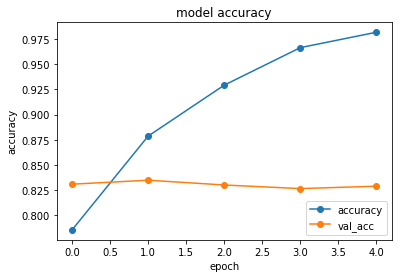

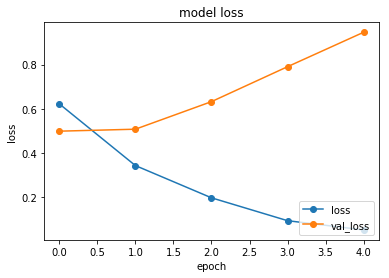

In [49]:
plot_history(history)

In [50]:
loss_and_metrics_yahoo = model.evaluate(X_test,Y_test)
loss_and_metrics_livedoor = model.evaluate(Livedoor_X,Livedoor_Y)
print("\n <Yahoo> loss:{} accuracy:{}"
      .format(loss_and_metrics_yahoo[0],loss_and_metrics_yahoo[1]))
print("\n <Livedoor> loss:{} accuracy:{}"
      .format(loss_and_metrics_livedoor[0],loss_and_metrics_livedoor[1]))

1729/1729 [==============================] - 0s 106us/step

 <Yahoo> loss:0.89249539185825 accuracy:0.829027265271256

 <Livedoor> loss:3.432277790861643 accuracy:0.5691150954308849


結果データの作成

In [36]:
def getAttentionVectors(X):
    layer_name = "attention"
    attention_layer_model = Model(inputs=LSTM_Model.input,
                                 outputs=LSTM_Model.get_layer(layer_name).output)
    attention_output = attention_layer_model.predict(X)
    attention_vectors=attention_output.reshape(attention_output.shape[0],
                                               attention_output.shape[-1])
    print(attention_vectors.shape)
    return attention_vectors

In [37]:
def getEncodedVectors(X):
    layer_name = 'encoder'
    encoder_layer_model = Model(inputs=LSTM_Model.input,
                                 outputs=LSTM_Model.get_layer(layer_name).output)
    encoded_vectors = encoder_layer_model.predict(X)
    print(encoded_vectors.shape)
    pca = PCA()
    pca.fit(encoded_vectors)
    pca_results = pca.fit_transform(encoded_vectors)[:,:3]
    print(pca_results.shape)
    return encoded_vectors,pca_results

In [38]:
def getProperties(X,Y):
    correct_wrong=[]
    answer_category=[]
    outputs=LSTM_Model.predict(X)
    for i in range(len(outputs)):
        answer_category.append(int(outputs[i].argmax()))
        if int(outputs[i].argmax())==int(Y[i].argmax()):
            correct_wrong.append(1)
        else:
            correct_wrong.append(0)
    return correct_wrong,answer_category

In [39]:
def create_json(X,Y,T,savepath):
    attention_vectors=getAttentionVectors(X)
    encoded_vectors,pca_results=getEncodedVectors(X)
    correct_wrong,answer_category=getProperties(X,Y)
    dic={}
    dic["result"]=[]
    for i in range(len(X)):
        inner_dic={}
        inner_dic["id"]=i
        inner_dic["title"]=T[i]
        inner_dic["category_num"]=list(Y[i]).index(1)
        inner_dic["output_category_num"]=answer_category[i]
        inner_dic["encoded_vector"]=list(map(float,encoded_vectors[i]))
        inner_dic["pca_result"]=list(map(float,pca_results[i]))
        inner_dic["correct"]=correct_wrong[i]
        inner_dic["attention"]=list(map(float,attention_vectors[i]))
        dic["result"].append(inner_dic)
    with open(savepath, 'w') as outfile:
        json.dump(dic, outfile)

In [40]:
#create_json(X_test,Y_test,T_test,"bow_yahoo.json")

NameError: name 'T_test' is not defined